In [1]:
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import train_test_split

In [2]:
def make_meshgrid(x, y, h=.02):
    d = 5
    x_min, x_max = x.min() - d, x.max() + d
    y_min, y_max = y.min() - d, y.max() + d
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return xx, yy

def plot_contours(clf, xx, yy, **params):
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = plt.contourf(xx, yy, Z, **params)
    return out

In [3]:
class QDA():

    def __init__(
        self, *, priors=None, reg_param=0.0, store_covariance=False, tol=1.0e-4
    ):
        self.priors = priors # pi-coefficients in discriminant analysis decision function
        self.reg_param = reg_param  # regression parameter
        self.store_covariance = store_covariance
        self.tol = tol

    def fit(self, X, y):
        self.classes_, y = np.unique(y, return_inverse=True) # also returns indexes to match input array
        n_samples, n_features = X.shape
        n_classes = len(self.classes_)
        if n_classes < 2:
            raise ValueError(
                "The number of classes has to be greater than one; got %d class"
                % (n_classes)
            )
        if self.priors is None:
            # bincount is histogram analog (makes interger interval from min to max and count corresponding numbers)
            self.priors_ = np.bincount(y) / float(n_samples) 
        else:
            self.priors_ = np.array(self.priors)

        cov = None
        store_covariance = self.store_covariance
        if store_covariance:
            cov = []
        # studying parameters
        means = []
        scalings = []
        rotations = []
        for ind in range(n_classes):
            Xg = X[y == ind, :]
            meang = Xg.mean(0)
            means.append(meang)
            if len(Xg) == 1:
                raise ValueError(
                    "y has only 1 sample in class %s, covariance is ill defined."
                    % str(self.classes_[ind])
                )
            Xgc = Xg - meang
            # Xgc = U * S * V.T
            _, S, Vt = np.linalg.svd(Xgc, full_matrices=False) # Singular Value Decomposition of Xgc
            rank = np.sum(S > self.tol)
            if rank < n_features:
                print("Variables are collinear")
            S2 = (S**2) / (len(Xg) - 1)
            S2 = ((1 - self.reg_param) * S2) + self.reg_param
            if self.store_covariance or store_covariance:
                # cov = V * (S^2 / (n-1)) * V.T
                cov.append(np.dot(S2 * Vt.T, Vt))
            scalings.append(S2)
            rotations.append(Vt.T)
        if self.store_covariance or store_covariance:
            self.covariance_ = cov
        self.means_ = np.asarray(means)
        self.scalings_ = scalings
        self.rotations_ = rotations
        return self

    def _decision_function(self, X):
        norm2 = []
        for i in range(len(self.classes_)):
            R = self.rotations_[i]
            S = self.scalings_[i]
            Xm = X - self.means_[i]
            X2 = np.dot(Xm, R * (S ** (-0.5)))
            norm2.append(np.sum(X2**2, axis=1))
        norm2 = np.array(norm2).T  # shape = [len(X), n_classes]
        u = np.asarray([np.sum(np.log(s)) for s in self.scalings_])
        return -0.5 * (norm2 + u) + np.log(self.priors_)

    def decision_function(self, X):
        dec_func = self._decision_function(X)
        # handle special case of two classes
        if len(self.classes_) == 2:
            return dec_func[:, 1] - dec_func[:, 0]
        return dec_func

    def predict(self, X):
        d = self._decision_function(X)
        y_pred = self.classes_.take(d.argmax(1))
        return y_pred

In [4]:
iris = datasets.load_iris()
X = iris.data[iris.target != 2][:, :2]  # sepal length, width
y = iris.target[iris.target != 2]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [5]:
clf = QDA()
clf.fit(X_train, y_train)
preds = clf.predict(X_test)
print(preds == y_test)

[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True]


Text(0.5, 1.0, 'QDA')

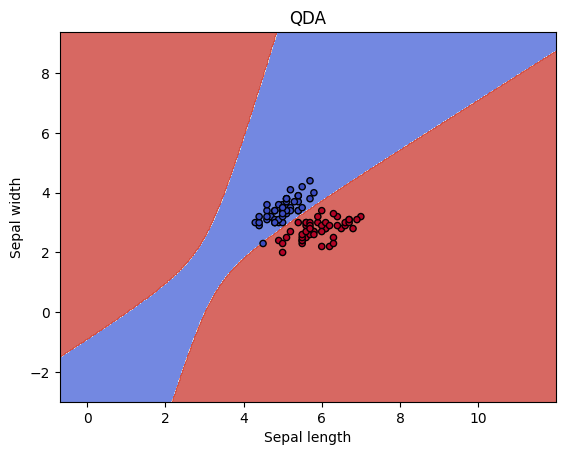

In [6]:
X0, X1 = X[:, 0], X[:, 1]
xx, yy = make_meshgrid(X0, X1)

plot_contours(clf, xx, yy,
                  cmap=plt.cm.coolwarm, alpha=0.8)
plt.scatter(X0, X1, c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')
plt.title("QDA")